# Inicializando o ambiente 

Para iniciar o ambiente da forma correta e garantir que tudo funcione da forma apropriada, execute o seguinte comando:

In [96]:
#pip install -r requirements.txt

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Definindo Helper Functions

In [98]:
def plot_na(df):
    na_data = {
        "OK": [(~df[column].isna()).sum() for column in df.columns],
        "NA": [df[column].isna().sum() for column in df.columns]
    }

    df_na = pd.DataFrame(na_data, index=df.columns)

    df_na["OK%"] = df_na["OK"] / df.shape[0] * 100
    df_na["NA%"] = df_na["NA"] / df.shape[0] * 100

    df_na = df_na.sort_values(by="NA%", ascending=True)

    fig = plt.figure(figsize=(16, 9))
    plt.barh(df_na.index, df_na["NA%"])
    for i, v in enumerate(df_na["NA%"]):
        plt.text(v + 0.5, i, f"{round(v, 2)}%", va="center")
    plt.title("Quantidade de dados ausentes por coluna")
    plt.grid(axis='x')
    #return fig

In [99]:
def map_list(lst, dic):
    for idx, item in enumerate(lst):
        if item in dic:
            lst[idx] = dic[item]
    return lst
    
def agrupando_valores_similares_lista(df, column, possibilities, group, blacklist=[], test_equal=False):
    dic = {}
    df_dic = {column: []}
    print(blacklist)
    if not test_equal:
        for row in df[column]:
            for item in row:
                for name in possibilities:
                    if name.upper() in item.upper() and item not in blacklist:
                        dic[item] = group
                        break
    else:
        for row in df[column]:
            for name in possibilities:
                if name in row:
                    dic[name] = group
                    break
    # for possibility in possibilities:
    #     dic[possibility] = group
    print(dic)
    
    for row in df[column]:
        new_row = map_list(row, dic)
        df_dic[column].append(new_row)
    return pd.DataFrame(df_dic, index=df.index)

In [100]:
def remove_and_group_classes_alike(possibilities, df, group_name, blacklist=[]):
    aux_df = pd.DataFrame({'CORRETO': [0 for x in range(0, len(df))]}, index=df.index)
    for column in df.columns:
        for name in possibilities:
            if name.upper() in column.upper() and column not in blacklist:
                aux_df = pd.concat([aux_df, df[df.columns[df.columns.get_loc(column)]]], axis=1)
                df.drop(df.columns[df.columns.get_loc(column)], inplace=True, axis=1)
                break
    
    aux_df['CORRETO'] = aux_df[aux_df.columns[0:]].apply(
        lambda x: max(x),
        axis=1
    )
    df[group_name] = aux_df['CORRETO']
    return

In [101]:
def remove_and_group_identical_classes(possibilities, df, group_name, blacklist=[]):
    aux_df = pd.DataFrame({'CORRETO': [0 for x in range(0, len(df))]}, index=df.index)
    for column in df.columns:
        for name in possibilities:
            if name.upper() == column.upper() and column not in blacklist:
                aux_df = pd.concat([aux_df, df[df.columns[df.columns.get_loc(column)]]], axis=1)
                df.drop(df.columns[df.columns.get_loc(column)], inplace=True, axis=1)
                break
    
    aux_df['CORRETO'] = aux_df[aux_df.columns[0:]].apply(
        lambda x: max(x),
        axis=1
    )
    df[group_name] = aux_df['CORRETO']
    return

In [102]:
def count_list_in_df(df, column):
    count = {}
    for row in df[column]:
        for lst in row:
            if lst not in count:
                count[lst] = 1
            else:
                count[lst] += 1
    return count

## Carregando os dados

In [103]:
df = pd.read_excel('sods.xlsx')

In [104]:
len(df)

4271

In [105]:
df.head(3)

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...


# Seleção

Nesta primeira etapa, selecionamos um subconjunto de dados relevantes para o objetivo da análise. A ideia é identificar e extrair informações específicas de um conjunto maior que possam contribuir diretamente para o objetivo da descoberta de conhecimento.

## Escolha das colunas

Com o objetivo de fundamentar nossas escolhas das colunas que permanecerão, selecionamos alguns artigos para justificar o motivo de termos optado por ficar com todas as colunas. 

Inicialmente, como divulgado no artigo `A influência de fatores demográficos e estruturais nos significados do trabalho entre brasileiros: evidências do World Values Survey` - https://doi.org/10.22296/2317-1529.rbeur.202205, aspectos culturais e de socialização, como a ideia de trabalho como responsabilidade social e as diferenças de gênero, podem influenciar as carreiras e tipos de empregos que os indivíduos de diferentes estados escolhem, moldando suas trajetórias profissionais de acordo com o ambiente socioeconômico de sua região de origem. Isso significa que informações como faixa etária, local de moradia, desenvolvimento pessoal e humano podem ter efeito dentro da escolha de um cargo na vida do indivíduo, por esse motivo iremos pernacer com as colunas `estado_moradia`, `idade`, `genero`, `nivel_ensino`, `etnia` e `pdc`.

Corroborando com essa afirmação, temos também os seguintes artigos: 
 * `Vantagens comparativas reveladas e divisão inter-regional do trabalho na economia brasileira` - https://doi.org/10.22296/2317-1529.rbeur.202205
 * `Mercado de Trabalho e Desigualdades Regionais no Brasil` - https://www5.pucsp.br/eitt/downloads/vi_ciclo_alexandre_barbosa.pdf
 * `Geografia do trabalho no Brasil` - https://doi.org/10.4000/confins.5950

### Avaliando a quantidade de NaN por colunas:

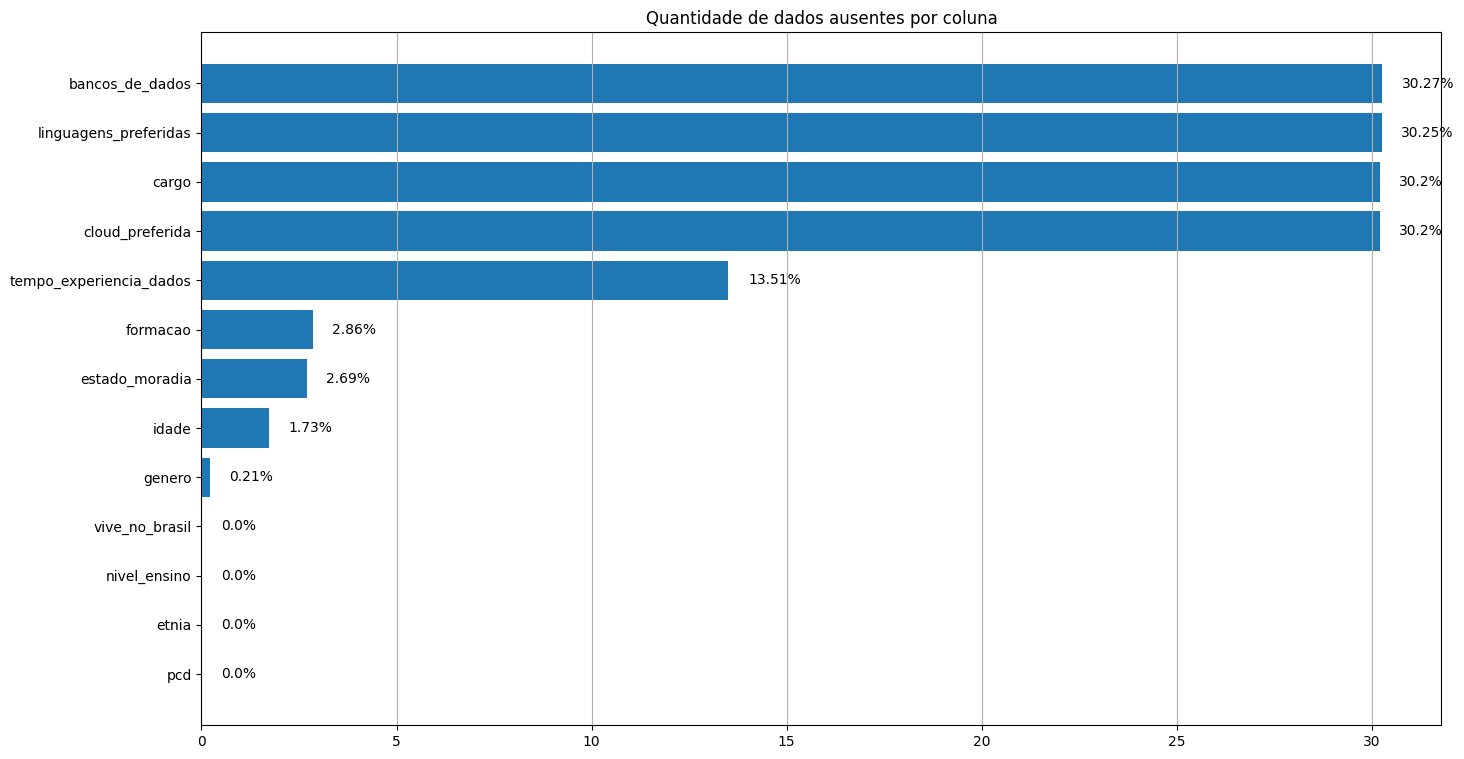

In [106]:
plot_na(df)

Apesar das colunas `bancos_de_dados`, `linguagens_preferidas`, `cargo` e `cloud_preferida` possuírem uma grande quantidade de dados nulos, elas coincidêm nesse quesito. Ou seja, quando a coluna linguagens_preferidas está nula, todas as outras também estão. Isso facilita a limpeza por linhas, então não será necessário excluir essas colunas.

#### Corrigindo dados faltantes da coluna `estado_moradia` para pessoas que moram fora do país

In [107]:
df.loc[df['vive_no_brasil'] == False, ['estado_moradia']] = False

In [108]:
df.loc[df['vive_no_brasil'] == False, ['estado_moradia']] = 'Não mora no Brasil'

In [109]:
df[df['vive_no_brasil'] == False].head(3)

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
51,37.0,Feminino,Branca,Não,False,Não mora no Brasil,Mestrado,Estatística/ Matemática / Matemática Computaci...,de 1 a 2 anos,Python,"SQL SERVER, MySQL, PostgreSQL, Google BigQuery",Google Cloud (GCP),Cientista de Dados/Data Scientist
106,31.0,Feminino,Preta,Não,False,Não mora no Brasil,Pós-graduação,Economia/ Administração / Contabilidade / Fina...,NaN,NaN,NaN,NaN,NaN
109,33.0,Masculino,Parda,Não,False,Não mora no Brasil,Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 4 a 6 anos,Python,"Google BigQuery, PostgreSQL",Não sei opinar,Analista de Dados/Data Analyst


Considerando que já podemos inferir a informação da coluna `vive_no_brasil` a partir da coluna `estado_moradia` e já foi feito o tratamento necessário, iremos eliminar essa coluna.

In [110]:
df = df.drop(['vive_no_brasil'], axis=1)
df.head(3)

,idade,genero,etnia,pcd,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...


## Teste RETIRE ME

In [111]:
# df = df.drop(['genero', 'etnia', 'pcd', 'estado_moradia'], axis=1)
# df.head(3)

#### Eliminando linhas com dados faltantes

In [112]:
no_nan_df = df.dropna()

# Transformação

Aqui, os dados são transformados e organizados para facilitar a mineração. Isso inclui a normalização, agregação e a criação de novos atributos que possam simplificar ou agregar valor ao processo de mineração de dados.

## Avaliando a quantidade de valores únicos por coluna

In [113]:
for column in no_nan_df.columns:
    print(f'{column}: {no_nan_df[column].nunique()}')

idade: 37
genero: 3
etnia: 7
pcd: 3
estado_moradia: 23
nivel_ensino: 5
formacao: 9
tempo_experiencia_dados: 7
linguagens_preferidas: 36
bancos_de_dados: 1415
cloud_preferida: 5
cargo: 18


## Tratando a coluna `banco_de_dados`

Ao analisar a coluna `banco_de_dados`, percebemos que ela está como string de vários valores separados por vírgura. Como exempleficado pela seguinte linha:

In [114]:
no_nan_df['bancos_de_dados'].head()[0]

'PostgreSQL, Oracle, MySQL, SQL SERVER'

Para trabalharmos com ela, precisaremos fazer o split dessas string a cada símbolo ', '.

In [115]:
no_nan_df.loc[:,'bancos_de_dados'] = no_nan_df['bancos_de_dados'].str.split(', ')

Dessa forma, obteremos uma lista de strings contendo os valores desejados separados da forma apropriada.

In [116]:
no_nan_df['bancos_de_dados'].head()[0]

['PostgreSQL', 'Oracle', 'MySQL', 'SQL SERVER']

Agora temos uma quantidade bem mais realista de diferentes bancos de dados.

In [117]:
len(count_list_in_df(no_nan_df, 'bancos_de_dados'))

179

## Agrupando dados similares

### Coluna `bancos_de_dados`

Nossa próxima etapa é verificar se há valores diferentes representando o mesmo objeto de estudo, isso diminuirá a quantidade de valores únicos que precisarão ser computados, diminuindo o tempo de processamento e facilitando a convergência dos modelos.

Fazendo uma análise mais profunda na coluna `bancos_de_dados`, percebemos que há várias respostas diferentes que tem o mesmo significado, como exemplificado pela célula abaixo: 

In [118]:
for key in dict(sorted(count_list_in_df(no_nan_df, 'bancos_de_dados').items())).keys():
    if 'azure'.upper() in key.upper():
        print(key)

Azure
Azure ADLS
Azure Blob Storage
Azure Data Explorer
Azure Data Lake
Azure Data lake
Azure SQL
Azure Storage Account
Azure Synapse
Azure blob storage
Consumo de APIS com azure functions
MS Azure


Para resolver isso, foi necessário utilizar a helper function criada anteriormente chamada `agrupando_valores_similares_lista`. Essa função agrupa valores considerados similares em um único atributo. A etapa seguinte utiliza justamente essa função para mapear e agrupar as respostas de mesmo valor semântico.

#### Unindo objetos como CSV e EXCEL em uma única classe chamada 'Tabelas'

In [119]:
possibilities = ['excel', 'csv', 'office']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities, group='Tabelas')

[]
{'Bases Excel e csv extraídas direto no site': 'Tabelas', 'Excel': 'Tabelas', 'apenas Excel': 'Tabelas', 'EXCEL': 'Tabelas', 'Fontes da empresa em html ou csv': 'Tabelas', 'excel': 'Tabelas', 'nosso banco é no excel': 'Tabelas', '.CSV': 'Tabelas', 'Office': 'Tabelas'}


#### Corrigindo e agrupando classes com erros de escrita e siglas. Ex: Azur Data Lake/ADLS => Azure Data Lake

In [120]:
possibilities = ['MS Azure']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities, group='Azure')

[]
{'MS Azure': 'Azure'}


In [121]:
possibilities = ['Azure Data Lake', 'ADLS']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities, group='Azure Data Lake')

[]
{'Azure Data Lake': 'Azure Data Lake', 'Azure ADLS': 'Azure Data Lake', 'Azure Data lake': 'Azure Data Lake'}


In [122]:
possibilities = ['Synapse']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities, group='Azure Synapse')

[]
{'Synapse': 'Azure Synapse', 'Azure Synapse': 'Azure Synapse'}


In [123]:
possibilities = ['Azue Blob Storage','Azure Blob Storage' ]
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities, group='Azure Blob Storage')

[]
{'Azure blob storage': 'Azure Blob Storage', 'Azure Blob Storage': 'Azure Blob Storage', 'Azue Blob Storage': 'Azure Blob Storage'}


In [124]:
possibilities = ['Google Big Query', 'Google BigQuery']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Google BigQuery')

[]
{'Google BigQuery': 'Google BigQuery', 'Google Big Query': 'Google BigQuery'}


In [125]:
possibilities = ['Google Sheets']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Google Sheets')

[]
{'Google Sheets': 'Google Sheets', 'Google sheets': 'Google Sheets'}


In [126]:
possibilities = ['SharePoint']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='SharePoint')

[]
{'Sharepoint': 'SharePoint', 'Lista do Sharepoint': 'SharePoint', 'SharePoint': 'SharePoint'}


In [127]:
possibilities = ['ClickHouse'] 
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='ClickHouse')

[]
{'ClickHouse': 'ClickHouse', 'Clickhouse': 'ClickHouse'}


In [128]:
possibilities = ['Databricks']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Databricks')

[]
{'Databricks': 'Databricks', 'Databricks SQL': 'Databricks'}


In [129]:
possibilities = ['Google Cloud Storage', 'GCS']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Google Cloud Storage')

[]
{'Google Cloud Storage': 'Google Cloud Storage', 'GCS': 'Google Cloud Storage'}


#### Tratando bancos de dados não especificados como `OUTROS`. Ex: Dados geoespaciais, Banco de dados próprio da empresa, Base de dados local

In [130]:
possibilities = ['dados ',' dados','base ', 'API', 'fontes', 'inter', 'midias', 'propri', 'sistema', 'outro']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Outros')

[]
{'Base de dados local': 'Outros', 'interno': 'Outros', 'Dados não estruturados': 'Outros', 'sistema de crm': 'Outros', 'API': 'Outros', 'midias sociais': 'Outros', 'Banco de dados próprio da empresa': 'Outros', 'Base interna': 'Outros', 'Dados geoespaciais': 'Outros', 'Não possuímos um banco de dados.': 'Outros', 'não utilizamos banco de dados': 'Outros', 'Outro': 'Outros', 'Não trabalho com base de dados.': 'Outros', 'dados alternativos e dados internos da empresa': 'Outros', 'Interno': 'Outros', 'Dados públicos externos': 'Outros', 'Pesquisas empírica que eu coleto os dados': 'Outros', 'Solução proprietária': 'Outros', 'Não tenho acesso ao banco de dados devido ao compliance da empresa': 'Outros', 'Fontes internas e de clientes': 'Outros', 'Diversas fontes de marketing digital': 'Outros', 'Não utilizo bancos de dados.': 'Outros', 'Dados internos': 'Outros', 'Consumo de APIS com azure functions': 'Outros', 'Não trabalho com dados': 'Outros'}


In [131]:
possibilities = ['Google']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Outros',test_equal=True)

[]
{'Google': 'Outros'}


#### Limpando e agrupando variações de 'NENHUM'

In [132]:
possibilities = ['nenhum', 'não', 'transição', 'curso', 'nao', 'none', 'nd']
blacklist = ['Cassandra']
no_nan_df.loc[:, 'bancos_de_dados'] = agrupando_valores_similares_lista(no_nan_df, 'bancos_de_dados', possibilities,group='Nenhum', blacklist=blacklist)

['Cassandra']


{'NENHUM': 'Nenhum', 'Não utilizo.': 'Nenhum', 'Não atuo ainda nisso': 'Nenhum', 'Nenhuma': 'Nenhum', 'Não utiluzo': 'Nenhum', 'Não temos BD': 'Nenhum', 'Nenhum': 'Nenhum', 'não uso nenhum': 'Nenhum', 'Nao utilizo': 'Nenhum', 'Não utilizo nenhum': 'Nenhum', 'Nenhuma das respostas': 'Nenhum', 'nenhuma': 'Nenhum', 'Nenhum dos listados': 'Nenhum', 'nao utilizo': 'Nenhum', 'NÃO RECONHEÇO NENHUM': 'Nenhum', 'Não atuo na área ainda': 'Nenhum', 'estou em transição de carreira': 'Nenhum', 'Nao uso': 'Nenhum', 'Nenhum desses': 'Nenhum', 'Não uso': 'Nenhum', 'Não trabalho com banco diretamente': 'Nenhum', 'Não utilizo': 'Nenhum', 'Nenhum acima': 'Nenhum', 'Não uso BD no trabalho': 'Nenhum', 'somente em cursos': 'Nenhum', 'Nenhum dos citados acima': 'Nenhum', 'Não usamos': 'Nenhum', 'Não sei': 'Nenhum', 'Nda': 'Nenhum', 'Nao atuo na area de tech na empresa ainda': 'Nenhum', 'Não se aplica': 'Nenhum', 'Nenhum destes': 'Nenhum', 'Nd': 'Nenhum', 'none': 'Nenhum', 'nenhum': 'Nenhum'}


A partir da agregação dessas labels, foi possível reduzir de 177 labels únicas para 99 labels únicas

In [133]:
len(dict(sorted(count_list_in_df(no_nan_df, 'bancos_de_dados').items())))

99

Repetindo o mesmo teste com a tecnologia `Azure` temos o seguinte resultado:

In [134]:
for key in dict(sorted(count_list_in_df(no_nan_df, 'bancos_de_dados').items())).keys():
    if 'azure'.upper() in key.upper():
        print(key)

Azure
Azure Blob Storage
Azure Data Explorer
Azure Data Lake
Azure SQL
Azure Storage Account
Azure Synapse


Notamos agora a extinsão de respostas iguais por mudanças semânticas ou erros de escritas 

### Coluna `linguagens_preferidas`

Essa coluna segue pelo mesmo caminho que a `banco_de_dados`, então irei omitir a mesma explicação. O processo segue os mesmos passos.

In [135]:
no_nan_df['linguagens_preferidas'].nunique()

36

Visualizando os valores podemos visualizar que essa coluna também contém respostas diferentes com o mesmo significado. Para exemplificar isso, segue um slice da lista de nomes únicos dentro da coluna `linguagens_preferidas`

In [136]:
sorted(no_nan_df['linguagens_preferidas'].unique())[12:20]

['Nao atuo com programação',
 'Nenhum',
 'Nenhuma',
 'NÃO SEI',
 'Não sei',
 'Não uso',
 'Não utilizo',
 'PySpark']

Seguiremos o mesmo processo, só que utilizando uma função diferente, pois a estrutura de dados não é mais um fila. Porém, a função cumprirá o mesmo propósito que a outra apresentada anteriormente, a partir de um mapeamento, agrupar valores com significado semântico igual.

In [137]:
mapping = {
    'java': 'Java',
    'M Language': 'M',
    'Nao atuo com programação':'Nenhum',
    'Nenhuma': 'Nenhum',
    'NÃO SEI': 'Nenhum',
    'Não sei': 'Nenhum',
    'Não uso': 'Nenhum',
    'Não utilizo': 'Nenhum',
    'Softwares estatísticos como spss': 'Nenhum',
    'Excel': 'Nenhum',
    'SQL Postegres': 'SQL',
    'xlsx': 'Nenhum',
    'sql': 'SQL',
    'Aql': 'SQL',
    'PySpark': 'Python',
    'spark': 'Spark',
    }

def apply_mapping(df, column, mappin):
    for idx, row in zip(df.index, df[column]):
        if row in mappin:
            df.loc[idx, column] = mappin[row]

Agrupando esses valores conseguimos reduzir de 36 valores únicos para 20 valores únicos.

In [138]:
apply_mapping(no_nan_df, 'linguagens_preferidas', mappin=mapping)

In [139]:
no_nan_df['linguagens_preferidas'].nunique()

20

In [140]:
sorted(no_nan_df['linguagens_preferidas'].unique())

['C/C++/C#',
 'Clojure',
 'Dax',
 'Elixir',
 'Go',
 'Java',
 'Julia',
 'KQL',
 'M',
 'Nenhum',
 'Python',
 'R',
 'Rust',
 'SQL',
 'Sas',
 'Scala',
 'Spark',
 'Sql',
 'VBA',
 'javascript']

## Balanceamento das classes

Ao avaliar as classes da coluna `cargo`, percebemos que as classes estão desbalanceadas.

In [141]:
no_nan_df['cargo'].value_counts()

cargo
Analista de Dados/Data Analyst                                         619
Cientista de Dados/Data Scientist                                      547
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    473
Analista de BI/BI Analyst                                              368
Outra Opção                                                            244
Analista de Negócios/Business Analyst                                  118
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas            101
Analytics Engineer                                                      68
Engenheiro de Machine Learning/ML Engineer                              67
Analista de Suporte/Analista Técnico                                    63
Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)                      49
Analista de Inteligência de Mercado/Market Intelligence                 28
Outras Engenharias (não inclui dev)                                     27
Professor          

Para evitar problemas relacionados com viés e escala de representação diferente entre as diferentes classes, faremos a utilização de técnicas de balanceamento de classes. Nesse contexto, para manter a simplicidade e a representação dos dados, iremos utilizar a técnica chamada de `undersampling` ou `downsampling`.

O processo que aplicaremos consiste em 2 passos simples:
 * Definição do número de amostras.
 * Escolha de um número de amostras X de forma aleatória para cada classe.

In [142]:
num_samples = 11

samples = [no_nan_df[no_nan_df['cargo'] == label].sample(num_samples, random_state=10) for label in no_nan_df['cargo'].unique()]

In [143]:
no_nan_df = pd.concat(samples)
no_nan_df.head(3)

,idade,genero,etnia,pcd,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
450,29.0,Masculino,Branca,Não,Minas Gerais (MG),Estudante de Graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,Python,[Oracle],Azure (Microsoft),DBA/Administrador de Banco de Dados
2101,41.0,Masculino,Preta,Não,Goiás (GO),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Mais de 10 anos,Python,"[PostgreSQL, Hive, MongoDB, MySQL, Oracle, DB2...",Google Cloud (GCP),DBA/Administrador de Banco de Dados
2794,18.0,Masculino,Parda,Não,São Paulo (SP),Estudante de Graduação,Computação / Engenharia de Software / Sistemas...,Menos de 1 ano,Python,"[SQL SERVER, Oracle, MySQL]",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados


In [144]:
no_nan_df = no_nan_df.sample(frac=1)
no_nan_df.head(3)

,idade,genero,etnia,pcd,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
3581,27.0,Masculino,Branca,Não,Mato Grosso do Sul (MS),Pós-graduação,Economia/ Administração / Contabilidade / Fina...,Menos de 1 ano,Python,"[MySQL, Firebase]",Amazon Web Services (AWS),Outra Opção
1297,27.0,Feminino,Branca,Não,Pernambuco (PE),Mestrado,Outras Engenharias,Não tenho experiência na área de dados,Python,[Google BigQuery],Amazon Web Services (AWS),Outras Engenharias (não inclui dev)
1583,39.0,Feminino,Branca,Não,Paraná (PR),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,Mais de 10 anos,Python,[Google BigQuery],Google Cloud (GCP),Analista de Negócios/Business Analyst


Com o processo completo, agora temos uma base amostral balanceada, único processo faltante para completar o processo de transformação é a vetorização das categorias e das classes

In [145]:
sampled_df = no_nan_df.reset_index(drop=True)
sampled_df['cargo'].value_counts()

cargo
Outra Opção                                                            11
Outras Engenharias (não inclui dev)                                    11
Analista de Negócios/Business Analyst                                  11
Analytics Engineer                                                     11
Engenheiro de Machine Learning/ML Engineer                             11
Cientista de Dados/Data Scientist                                      11
DBA/Administrador de Banco de Dados                                    11
Analista de Inteligência de Mercado/Market Intelligence                11
Estatístico                                                            11
Analista de Suporte/Analista Técnico                                   11
Economista                                                             11
Analista de Dados/Data Analyst                                         11
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas            11
Engenheiro de Dados/Arquiteto de

In [146]:
sampled_df.head(3)

,idade,genero,etnia,pcd,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,27.0,Masculino,Branca,Não,Mato Grosso do Sul (MS),Pós-graduação,Economia/ Administração / Contabilidade / Fina...,Menos de 1 ano,Python,"[MySQL, Firebase]",Amazon Web Services (AWS),Outra Opção
1,27.0,Feminino,Branca,Não,Pernambuco (PE),Mestrado,Outras Engenharias,Não tenho experiência na área de dados,Python,[Google BigQuery],Amazon Web Services (AWS),Outras Engenharias (não inclui dev)
2,39.0,Feminino,Branca,Não,Paraná (PR),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,Mais de 10 anos,Python,[Google BigQuery],Google Cloud (GCP),Analista de Negócios/Business Analyst


## Vetorização de Dados Categóricos utilizando OneHotEncoder

Como os atributos com os quais iremos trabalhar não têm uma ordem natural e usaremos modelos sensíveis a valores ordinais (regressão logística), foi optado por usar essa técnica para a representação vetorial dos dados categóricos.

Nota: devido a coluna `bancos_de_dados` ter múltiplos valores por linha, iremos utilizar um outro método para sua vetorização.

In [147]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder

In [148]:
ohe_encoder = OneHotEncoder(sparse_output=False)

In [149]:
categorical_data = ['genero', 'etnia', 'pcd', 'estado_moradia',
       'nivel_ensino', 'formacao', 'tempo_experiencia_dados',
       'linguagens_preferidas', 'cloud_preferida']

In [150]:
encoded_data = ohe_encoder.fit_transform(sampled_df[categorical_data])
encoded_data

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [151]:
feature_names = ohe_encoder.get_feature_names_out()

In [152]:
ohe_df = pd.DataFrame(encoded_data, columns=feature_names)
ohe_df.head(3)

,genero_Feminino,genero_Masculino,etnia_Amarela,etnia_Branca,etnia_Indígena,etnia_Parda,etnia_Preta,pcd_Não,pcd_Prefiro não informar,pcd_Sim,...,linguagens_preferidas_Julia,linguagens_preferidas_Nenhum,linguagens_preferidas_Python,linguagens_preferidas_R,linguagens_preferidas_SQL,linguagens_preferidas_Scala,cloud_preferida_Amazon Web Services (AWS),cloud_preferida_Azure (Microsoft),cloud_preferida_Google Cloud (GCP),cloud_preferida_Não sei opinar
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [153]:
not_encoded_df = sampled_df.drop(categorical_data, axis=1).reset_index(drop=True)
not_encoded_df.head(3)

,idade,bancos_de_dados,cargo
0,27.0,"[MySQL, Firebase]",Outra Opção
1,27.0,[Google BigQuery],Outras Engenharias (não inclui dev)
2,39.0,[Google BigQuery],Analista de Negócios/Business Analyst


In [154]:
df_semi_transformed = pd.concat([not_encoded_df, ohe_df], axis=1)
df_semi_transformed.head(3)

,idade,bancos_de_dados,cargo,genero_Feminino,genero_Masculino,etnia_Amarela,etnia_Branca,etnia_Indígena,etnia_Parda,etnia_Preta,...,linguagens_preferidas_Julia,linguagens_preferidas_Nenhum,linguagens_preferidas_Python,linguagens_preferidas_R,linguagens_preferidas_SQL,linguagens_preferidas_Scala,cloud_preferida_Amazon Web Services (AWS),cloud_preferida_Azure (Microsoft),cloud_preferida_Google Cloud (GCP),cloud_preferida_Não sei opinar
0,27.0,"[MySQL, Firebase]",Outra Opção,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,27.0,[Google BigQuery],Outras Engenharias (não inclui dev),1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,39.0,[Google BigQuery],Analista de Negócios/Business Analyst,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Agora vamos fazer a vetorização da coluna `bancos_de_dados`. Como essa coluna contém vários valores por cada linha, iremos utilizar o método `MultiLabelBinarizer`, que segue a mesma ideia do OneHotEncoder porém que pode ser aplicado em dados onde uma célula pode conter múltiplas labels.

In [155]:
mlb = MultiLabelBinarizer()

In [156]:
mlb_df =  pd.DataFrame(mlb.fit_transform(df_semi_transformed['bancos_de_dados']), columns=mlb.classes_)
mlb_df.head(3)

,Amazon Athena,Amazon Aurora ou RDS,Amazon Redshift,Azure,Azure Data Lake,DB2,Databricks,Datomic,DynamoDB,Elaticsearch,...,SAS,SQL SERVER,SQLite,Snowflake,Splunk,Sybase,Tabelas,Teradata,Vertica,sas
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
df_semi_transformed = df_semi_transformed.drop(['bancos_de_dados'], axis=1)
df_semi_transformed = pd.concat([df_semi_transformed, mlb_df], axis=1)


In [158]:
df_semi_transformed.head(3)

,idade,cargo,genero_Feminino,genero_Masculino,etnia_Amarela,etnia_Branca,etnia_Indígena,etnia_Parda,etnia_Preta,pcd_Não,...,SAS,SQL SERVER,SQLite,Snowflake,Splunk,Sybase,Tabelas,Teradata,Vertica,sas
0,27.0,Outra Opção,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,27.0,Outras Engenharias (não inclui dev),1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,39.0,Analista de Negócios/Business Analyst,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Vetorização das classes utilizando Label Encoding

Essa técnica consiste em atribuir um número inteiro único a cada categoria. Por exemplo, "vermelho" = 0, "azul" = 1, "verde" = 2.

In [159]:
from sklearn.preprocessing import LabelEncoder

In [160]:
label_encoder = LabelEncoder()
encoded_cargo = label_encoder.fit_transform(df_semi_transformed['cargo'])
df_transformed = df_semi_transformed.drop(columns=['cargo'])
df_transformed['cargo'] = encoded_cargo
df_transformed.head(3)

,idade,genero_Feminino,genero_Masculino,etnia_Amarela,etnia_Branca,etnia_Indígena,etnia_Parda,etnia_Preta,pcd_Não,pcd_Prefiro não informar,...,SQL SERVER,SQLite,Snowflake,Splunk,Sybase,Tabelas,Teradata,Vertica,sas,cargo
0,27.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,14
1,27.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,15
2,39.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,4


In [161]:
labels = label_encoder.classes_

In [162]:
df_transformed.describe()

,idade,genero_Feminino,genero_Masculino,etnia_Amarela,etnia_Branca,etnia_Indígena,etnia_Parda,etnia_Preta,pcd_Não,pcd_Prefiro não informar,...,SQL SERVER,SQLite,Snowflake,Splunk,Sybase,Tabelas,Teradata,Vertica,sas,cargo
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,31.070707,0.227273,0.772727,0.010101,0.651515,0.005051,0.267677,0.065657,0.984848,0.005051,...,0.247475,0.050505,0.040404,0.015152,0.005051,0.020202,0.010101,0.005051,0.005051,8.500000
std,7.132897,0.420132,0.420132,0.100248,0.477698,0.071067,0.443870,0.248309,0.122465,0.071067,...,0.432639,0.219540,0.197404,0.122465,0.071067,0.141047,0.100248,0.071067,0.071067,5.201279
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,30.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000
75%,36.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
max,54.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000


## Separando dados de extração de conhecimento e dados de classes

In [163]:
X = df_transformed.iloc[:, :-1].to_numpy()
y = df_transformed.iloc[:, -1].to_numpy()

In [164]:
X

array([[27.,  0.,  1., ...,  0.,  0.,  0.],
       [27.,  1.,  0., ...,  0.,  0.,  0.],
       [39.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [29.,  0.,  1., ...,  0.,  0.,  0.],
       [23.,  0.,  1., ...,  0.,  0.,  0.],
       [40.,  0.,  1., ...,  0.,  0.,  0.]])

In [165]:
y

array([14, 15,  4,  6, 12, 15,  7,  8,  6,  4,  2, 13,  4,  5, 10,  1,  9,
       11, 11,  0, 17, 10, 11, 15,  4, 10,  5,  6,  2, 13,  9,  8,  2, 16,
       17,  1,  7, 14, 15,  2,  0, 12, 13,  6, 17, 12,  4,  4, 16,  6,  0,
       11, 14,  7,  7, 16, 10,  5,  5, 17,  5,  6,  3, 16,  7, 12,  7, 10,
       14, 17,  9,  5,  1, 16, 12, 14,  7, 17,  5,  9, 14,  7, 11,  3,  0,
        6,  9, 13,  4,  1,  4,  4, 12,  2, 11,  8,  3, 13,  1,  0,  5, 16,
        8, 14, 16, 12,  0,  2, 14,  9, 13, 10,  0, 17, 15,  4,  1, 13,  2,
        3,  9,  1, 15,  2, 12, 16, 14,  6,  7,  3, 17,  2, 17,  1,  7, 17,
       10, 16, 15, 15,  0,  0, 15, 10, 10,  6, 14,  0,  2, 12,  7, 10, 11,
        8,  5, 17,  8,  3, 10,  1,  3, 13,  1,  5, 13, 14, 16, 11,  9,  3,
       13,  6,  9,  9,  3, 16,  8,  4,  3, 11, 11, 12,  2,  8, 11,  8, 15,
       15,  1,  8,  8, 13,  0,  9,  3,  5, 12,  6])

# Mineração de Dados

 Esta etapa é o coração do processo, onde técnicas e algoritmos (como clustering, classificação, regressão, entre outros) são aplicados para extrair padrões.

### Divisão de teste e treino

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10, stratify=y)

In [168]:
df_shapes = pd.DataFrame({
    "X": [X_train.shape, X_test.shape],
    "Y": [y_train.shape, y_test.shape]
})

df_shapes.index = ["train", "test"]
df_shapes

,X,Y
train,"(138, 108)","(138,)"
test,"(60, 108)","(60,)"


### Criação dos modelos, data standardization e treinamento

#### Criando uma Pipeline

##### Logistic Regression

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

Como a Regressão Logística é sensível a escalas e dependendo de como as escalas dos dados estiverem o modelo pode demorar mais para convergir, utilizaremos uma técnica chamada de StandardScaler, sendo seu objetivo principal transformar as variáveis para que tenham uma média de 0 e um desvio padrão de 1, resultando em uma distribuição normalizada (ou próxima da normal), acelerando a etapa de convergência.

In [170]:
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression())

In [171]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

##### Random Forest

In [172]:
rf = RandomForestClassifier()

In [173]:
rf.fit(X_train, y_train)

RandomForestClassifier()

# Avaliação

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

##### Logistic Regression

In [175]:
y_pred_lr=lr_pipeline.predict(X_test)
y_pred_lr

array([ 5, 10,  6,  4, 17, 11, 15, 17,  8, 17, 10, 12, 11,  1, 12,  2,  6,
        6, 14,  6,  2, 11, 13, 17, 12, 14,  5, 10, 12,  8,  1, 16,  8,  8,
        5,  1,  3, 15,  9, 11,  4, 12, 14,  7, 15,  5, 12,  8, 13,  2,  6,
        2, 13, 10,  2, 10,  9,  6, 17,  0])

In [176]:
cm_lr = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_lr,
)

cm_lr

array([[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2,

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Analista de BI/BI Analyst'),
  Text(1, 0, 'Analista de Dados/Data Analyst'),
  Text(2, 0, 'Analista de Inteligência de Mercado/Market Intelligence'),
  Text(3, 0, 'Analista de Marketing'),
  Text(4, 0, 'Analista de Negócios/Business Analyst'),
  Text(5, 0, 'Analista de Suporte/Analista Técnico'),
  Text(6, 0, 'Analytics Engineer'),
  Text(7, 0, 'Cientista de Dados/Data Scientist'),
  Text(8, 0, 'DBA/Administrador de Banco de Dados'),
  Text(9, 0, 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas'),
  Text(10, 0, 'Economista'),
  Text(11, 0, 'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect'),
  Text(12, 0, 'Engenheiro de Machine Learning/ML Engineer'),
  Text(13, 0, 'Estatístico'),
  Text(14, 0, 'Outra Opção'),
  Text(15, 0, 'Outras Engenharias (não inclui dev)'),
  Text(16, 0, 'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)'),
  Text(17, 0, 'Profess

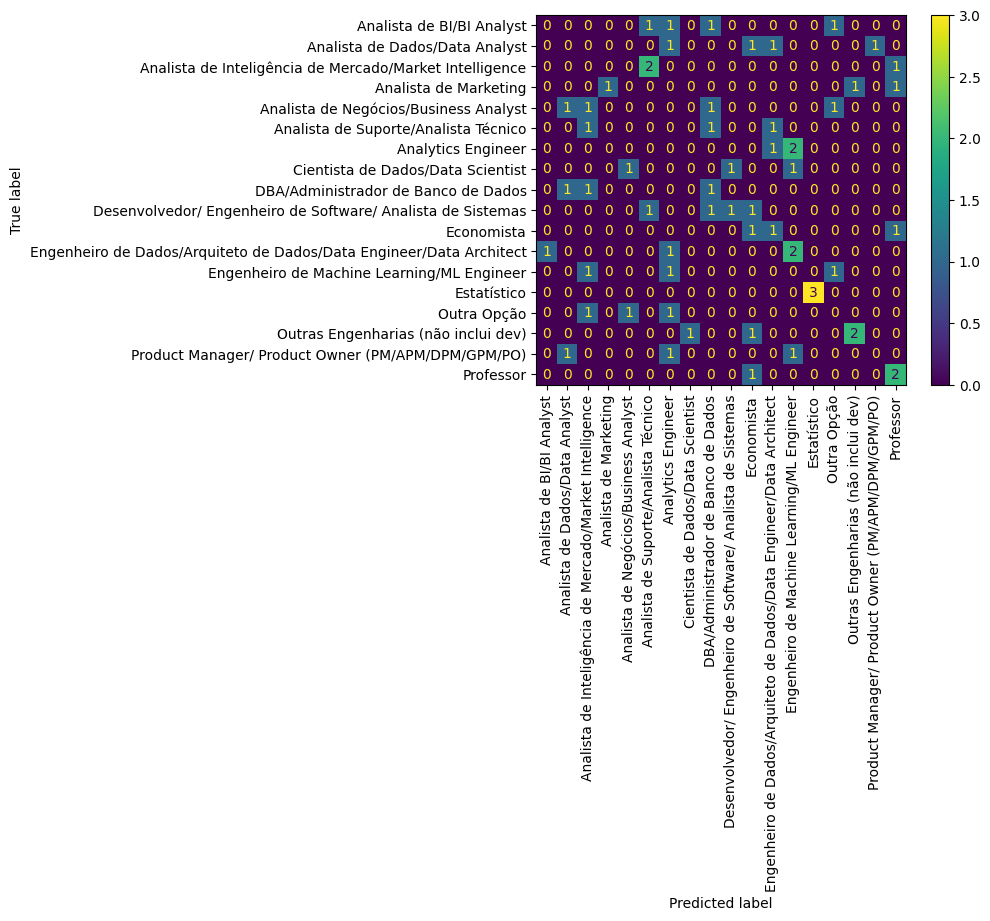

In [177]:
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=labels)
cm_display_lr.plot()
plt.xticks(rotation=90)

In [178]:
accuracy_score(y_test, y_pred_lr)

0.18333333333333332

In [179]:
precision_score(y_test, y_pred_lr, average='weighted')

np.float64(0.21777777777777776)

In [180]:
recall_score( y_test, y_pred_lr, average='weighted')

np.float64(0.18333333333333332)

In [181]:
f1_score(y_test, y_pred_lr, average='weighted')

np.float64(0.1853174603174603)

##### Random Forest

In [182]:
y_pred_rf=rf.predict(X_test)
y_pred_rf

array([12,  5, 15,  5, 10, 12,  2,  4,  8,  3,  3, 16, 10,  1, 16,  7,  7,
       10,  1,  7,  2,  5, 13, 16, 12, 14, 13, 10,  6,  8,  3, 16,  8,  5,
        5,  5, 15, 15,  9,  5,  7,  6,  5,  7, 15, 14,  5,  8, 13,  5, 15,
       17, 13,  9,  6,  5,  9, 15, 17,  0])

In [183]:
cm_rf = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_rf,
)

cm_rf

array([[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Analista de BI/BI Analyst'),
  Text(1, 0, 'Analista de Dados/Data Analyst'),
  Text(2, 0, 'Analista de Inteligência de Mercado/Market Intelligence'),
  Text(3, 0, 'Analista de Marketing'),
  Text(4, 0, 'Analista de Negócios/Business Analyst'),
  Text(5, 0, 'Analista de Suporte/Analista Técnico'),
  Text(6, 0, 'Analytics Engineer'),
  Text(7, 0, 'Cientista de Dados/Data Scientist'),
  Text(8, 0, 'DBA/Administrador de Banco de Dados'),
  Text(9, 0, 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas'),
  Text(10, 0, 'Economista'),
  Text(11, 0, 'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect'),
  Text(12, 0, 'Engenheiro de Machine Learning/ML Engineer'),
  Text(13, 0, 'Estatístico'),
  Text(14, 0, 'Outra Opção'),
  Text(15, 0, 'Outras Engenharias (não inclui dev)'),
  Text(16, 0, 'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)'),
  Text(17, 0, 'Profess

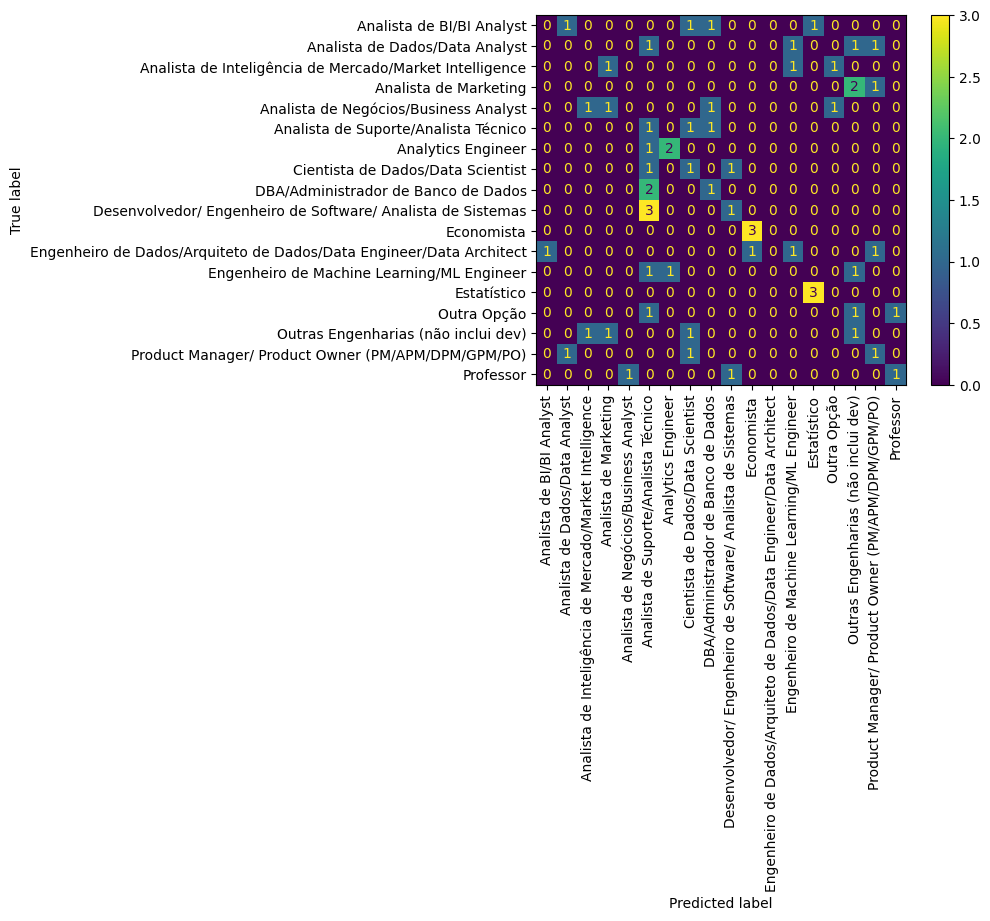

In [184]:
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
cm_display_rf.plot()
plt.xticks(rotation=90)

In [185]:
accuracy_score(y_test, y_pred_rf)

0.25

In [186]:
precision_score(y_test, y_pred_rf, average='weighted')

d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.20621212121212118)

In [187]:
recall_score(y_test, y_pred_rf, average='weighted')

np.float64(0.25)

In [188]:
f1_score(y_test, y_pred_rf, average='weighted')

np.float64(0.2196428571428571)

### Otimizando Hyper-parameters 

Considerando o resultado obtido anteriormente, vamos tentar melhorar o desempenho de nossos modelos.

Para isso vamos usar uma técnica chamada de GridSearch, uma técnica utilizada para otimizar hiperparâmetros de modelos de aprendizado de máquina. Ele realiza uma busca exaustiva em grid de valores possíveis para os hiperparâmetros, testando combinações específicas para identificar aquela que oferece o melhor desempenho do modelo em relação a uma métrica de avaliação definida

NOTA: Essa técnica pode utilizar um tempo considerável para ser executada a depender do tipo de mapeamento feito!

In [189]:
from sklearn.model_selection import GridSearchCV

##### Logistic Regression

In [190]:
lr_parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none', 'elasticnet', 'l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'max_iter': [10000, 100000]}]

In [191]:
lr_grid_search = GridSearchCV(LogisticRegression(), lr_parameters, cv=5, scoring='accuracy', n_jobs=1)

In [192]:
lr_grid_search.fit(X_train, y_train)

d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
910 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': [10000, 100000],
                          'penalty': ['none', 'elasticnet', 'l1', 'l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             scoring='accuracy')

In [193]:
lr_grid_search.best_estimator_

LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='saga')

In [194]:
lr_grid_search.best_params_

{'C': 1, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}

In [195]:
lr_grid_search.best_score_

np.float64(0.22513227513227513)

In [209]:
lr_op_pipeline = make_pipeline(LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='saga'))

In [210]:
lr_op_pipeline.fit(X_train, y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [211]:
y_pred_lr_op=lr_op_pipeline.predict(X_test)

In [212]:
accuracy_score(y_test, y_pred_lr_op)

0.23333333333333334

In [213]:
precision_score(y_test, y_pred_lr_op, average='weighted')

d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.1703174603174603)

In [214]:
recall_score(y_test, y_pred_lr_op, average='weighted')

np.float64(0.23333333333333334)

In [215]:
f1_score(y_test, y_pred_lr_op, average='weighted')

np.float64(0.18742063492063493)

##### Random Forest

In [216]:
rf_params = [{
    'n_estimators': [100,500,1000],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split': [10,15],
    'min_samples_leaf': [2,4],
    'max_depth': [10,20]
}]

In [217]:
rf_grid_search = GridSearchCV(rf, rf_params, cv=7, scoring='accuracy')

In [218]:
rf_grid_search.fit(X_train, y_train)

d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=7, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini', 'log_loss'],
                          'max_depth': [10, 20], 'min_samples_leaf': [2, 4],
                          'min_samples_split': [10, 15],
                          'n_estimators': [100, 500, 1000]}],
             scoring='accuracy')

In [219]:
rf_grid_search.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [220]:
rf_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [221]:
rf_grid_search.best_score_

np.float64(0.26052631578947366)

In [222]:
rf_optimized = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [223]:
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [224]:
rf_optimized.feature_importances_

array([0.06321644, 0.01090782, 0.01149899, 0.        , 0.01539556,
       0.        , 0.01232932, 0.00861344, 0.00147759, 0.        ,
       0.00089261, 0.        , 0.        , 0.00706529, 0.00075245,
       0.00637455, 0.00149977, 0.00013937, 0.00030383, 0.        ,
       0.        , 0.01525267, 0.0076998 , 0.00657734, 0.        ,
       0.        , 0.00129197, 0.00326195, 0.00978803, 0.00075196,
       0.        , 0.03107764, 0.01426159, 0.01081072, 0.02803609,
       0.00835445, 0.01886778, 0.00164164, 0.        , 0.05472573,
       0.05314895, 0.0425011 , 0.00611586, 0.00530727, 0.03901852,
       0.00327795, 0.02606749, 0.01500794, 0.02217324, 0.01918586,
       0.01378   , 0.01447879, 0.01242225, 0.00079302, 0.        ,
       0.        , 0.00631572, 0.01050136, 0.        , 0.        ,
       0.0160441 , 0.01999562, 0.03182979, 0.0126478 , 0.0237836 ,
       0.00077344, 0.01612798, 0.        , 0.        , 0.00075575,
       0.01985404, 0.        , 0.00150471, 0.00112416, 0.00192

In [225]:
rf_op_y_pred = rf_optimized.predict(X_test)
rf_op_y_pred

array([ 8, 10,  6,  8, 10, 15,  2, 16,  8, 10,  3, 16, 10,  6,  8,  7, 12,
       10,  3, 11,  6,  5, 13, 11, 12, 10, 13, 10,  6,  5,  3, 16,  8,  5,
        5,  5, 15, 15,  9,  8,  2,  6,  8,  7, 12, 10,  5,  8, 13,  5, 15,
        2, 13,  9,  6,  9,  9, 15, 14, 13])

In [226]:
cm_rf_op = confusion_matrix(
    y_true=y_test,
    y_pred=rf_op_y_pred,
)

cm_rf_op

array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Analista de BI/BI Analyst'),
  Text(1, 0, 'Analista de Dados/Data Analyst'),
  Text(2, 0, 'Analista de Inteligência de Mercado/Market Intelligence'),
  Text(3, 0, 'Analista de Marketing'),
  Text(4, 0, 'Analista de Negócios/Business Analyst'),
  Text(5, 0, 'Analista de Suporte/Analista Técnico'),
  Text(6, 0, 'Analytics Engineer'),
  Text(7, 0, 'Cientista de Dados/Data Scientist'),
  Text(8, 0, 'DBA/Administrador de Banco de Dados'),
  Text(9, 0, 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas'),
  Text(10, 0, 'Economista'),
  Text(11, 0, 'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect'),
  Text(12, 0, 'Engenheiro de Machine Learning/ML Engineer'),
  Text(13, 0, 'Estatístico'),
  Text(14, 0, 'Outra Opção'),
  Text(15, 0, 'Outras Engenharias (não inclui dev)'),
  Text(16, 0, 'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)'),
  Text(17, 0, 'Profess

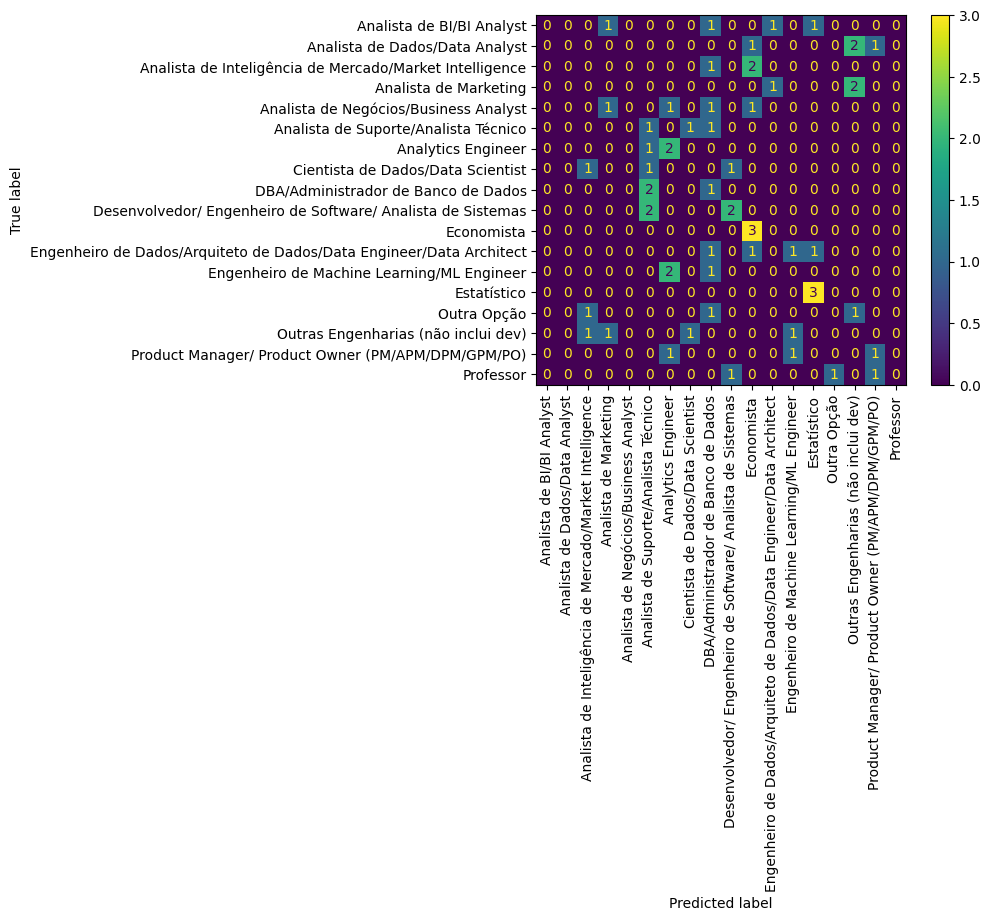

In [227]:
cm_display_rf_op = ConfusionMatrixDisplay(confusion_matrix=cm_rf_op, display_labels=labels)
cm_display_rf_op.plot()
plt.xticks(rotation=90)

In [228]:
accuracy_score(y_test, rf_op_y_pred)

0.21666666666666667

In [229]:
precision_score(y_test, rf_op_y_pred, average='weighted')

d:\Users\usuario\Documents\GitHub\IA_Classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.1288095238095238)

In [230]:
recall_score(y_test, rf_op_y_pred, average='weighted')

np.float64(0.21666666666666667)

In [231]:
f1_score(y_test, rf_op_y_pred, average='weighted')

np.float64(0.15608585858585858)

# Conclusão

Dentro do contexto apresentado e a partir dos processos desempenhados, chegamos à conclusão que o modelo que melhor desempenhou o processo inicalmente foi a Random Forest, apesar de ambos não terem scores de accuracy satisfatórios. Porém, após a otimização dos hyperparametros, o modelo que se demonstrou mais satisfatório foi a regressão logística, com um f1 score de 0.18, em detrimento da random forest com 0.15.